
# Using Python and pySpark
### Fluorescence, PRI and Carbon GPP relationships in Barbeau Forest 
 

### 1. Check is PySpark is available 

In [102]:
try:
    from pyspark import SparkContext
    print("PySpark is available in this machine")
except ImportError:
    print("PySpark is not installed in this machine, use pip manager to install Apache PySpark API Python")

PySpark is available in this machine


### 2. Open a PySpark session and give a name to the section

In [103]:
%reset -f
from pyspark.sql import SparkSession
# Create a SparkSession
spark = SparkSession.builder.appName("SIG_PRI_GPP").getOrCreate()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  

## 3. Open the CSV file and print colnames usin Spark : spectral data

In [104]:
path_name= "D:/ICOS_FrFonSunInducedFluorescence/SpectralData/"
file_name= "meta_HR_24_11_2023_GH.csv"
file=path_name+file_name
print(file)
# Read a CSV file into a DataFrame
df_SpecData = spark.read.csv(file, inferSchema=True, header=True, sep=';')
#print(df_SpecData.columns)
# Print column names, each on a new line
for column in df_SpecData.columns:
    print("Column name: " + column)

D:/ICOS_FrFonSunInducedFluorescence/SpectralData/meta_HR_24_11_2023_GH.csv
Column name: Time_start
Column name: Time_end
Column name: Integration_time
Column name: PAR_micromoles_m_2s_1
Column name: PAR_total_micromoles_m_2s_1
Column name: PAR_diffus_micromoles_m_2s_1
Column name: Sunflag
Column name: IRT0_SurfaceTemperature_celsius
Column name: IRT0_SensorTemperature_celsius
Column name: IRT1_SurfaceTemperature_celsius
Column name: IRT1_SensorTemperature_celsius
Column name: BOX_Temperature_celsius
Column name: BOX_RelativeHumidity_percent
Column name: HR_peltierCurrent_ampere
Column name: HR_radiatorTemperature_celsius
Column name: LR_peltierCurrent_ampere
Column name: LR_radiatorTemperature_celsius
Column name: sun_var
Column name: nbdark_sig
Column name: nbsp_nosig
Column name: nbsp_bad
Column name: prcdarkpix_sig
Column name: prcsppix_nosig
Column name: prcsppix_sat
Column name: dark_dpix_mean
Column name: dark_dpix_std
Column name: sp_dpix_mean
Column name: sp_dpix_std
Column nam

#### 3.1.  data Types

In [105]:
df_SpecData.printSchema()

root
 |-- Time_start: string (nullable = true)
 |-- Time_end: string (nullable = true)
 |-- Integration_time: integer (nullable = true)
 |-- PAR_micromoles_m_2s_1: double (nullable = true)
 |-- PAR_total_micromoles_m_2s_1: double (nullable = true)
 |-- PAR_diffus_micromoles_m_2s_1: double (nullable = true)
 |-- Sunflag: double (nullable = true)
 |-- IRT0_SurfaceTemperature_celsius: double (nullable = true)
 |-- IRT0_SensorTemperature_celsius: double (nullable = true)
 |-- IRT1_SurfaceTemperature_celsius: double (nullable = true)
 |-- IRT1_SensorTemperature_celsius: double (nullable = true)
 |-- BOX_Temperature_celsius: double (nullable = true)
 |-- BOX_RelativeHumidity_percent: double (nullable = true)
 |-- HR_peltierCurrent_ampere: double (nullable = true)
 |-- HR_radiatorTemperature_celsius: double (nullable = true)
 |-- LR_peltierCurrent_ampere: double (nullable = true)
 |-- LR_radiatorTemperature_celsius: double (nullable = true)
 |-- sun_var: double (nullable = true)
 |-- nbdark_s

#### 3.2. Show data of PySpark (equivalent to head() in Pandas)

In [106]:
df_SpecData=df_SpecData.select('Time_start','PAR_micromoles_m_2s_1', 'mNDI', 'NDVI', 'PRI', 'SIF_SFM_Co_tot')
df_SpecData.show()

+----------------+---------------------+----+----+----+--------------+
|      Time_start|PAR_micromoles_m_2s_1|mNDI|NDVI| PRI|SIF_SFM_Co_tot|
+----------------+---------------------+----+----+----+--------------+
|01/01/2022 00:02|               0.5871|NULL|NULL|-1.0|          NULL|
|01/01/2022 00:05|               0.5253|NULL|NULL|NULL|       -5.0E-5|
|01/01/2022 00:09|               0.4944| 0.0|NULL|NULL|          NULL|
|01/01/2022 00:13|               0.4944|NULL|NULL|NULL|          NULL|
|01/01/2022 00:17|               0.8343|NULL|NULL|NULL|          NULL|
|01/01/2022 00:20|               0.5871| 1.0|NULL|NULL|          NULL|
|01/01/2022 00:24|               0.5871|NULL|NULL|NULL|          NULL|
|01/01/2022 00:28|               0.4326|NULL|NULL|NULL|          NULL|
|01/01/2022 00:32|               0.8034|NULL|NULL|NULL|          NULL|
|01/01/2022 00:36|               0.5871|NULL|NULL|-1.0|          NULL|
|01/01/2022 00:39|               0.6489|NULL|NULL|NULL|          NULL|
|01/01

#### 3.3. Dealing with timeStamp in Spark
The two columns Time_Start and Time_End are Timestamp in format dd/MM/yyyy HH:MM. In Spark the two columns have string type. How to convert them to data and time in spark

In [107]:
from pyspark.sql.functions import to_timestamp
df_SpecData= df_SpecData.withColumn("Time_start", to_timestamp("Time_start", 'dd/MM/yyyy HH:mm'))
# Convert 'Time_Start' and 'Time_End' to datetime
df_SpectData = df_SpecData.withColumn("Time_start", to_timestamp("Time_start", 'dd/MM/yyyy HH:mm'))


In [108]:
df_SpectData.printSchema()

root
 |-- Time_start: timestamp (nullable = true)
 |-- PAR_micromoles_m_2s_1: double (nullable = true)
 |-- mNDI: double (nullable = true)
 |-- NDVI: double (nullable = true)
 |-- PRI: double (nullable = true)
 |-- SIF_SFM_Co_tot: double (nullable = true)



#### 3.4. Plot time series - Note that pyspark dataframe needs to be converted to pandas dataframe


##### 3.4.1. Convert Spark DataFrame to Pandas DataFrame


In [109]:
p_df_SpectData = df_SpectData.toPandas()

c:\Users\salsa\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\pandas\types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
c:\Users\salsa\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\pandas\types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


##### 3.4.2. Plot time series 

In [110]:

p_df_SpectData['Time_start'] = pd.to_datetime(p_df_SpectData['Time_start'])
p_df_SpectData.set_index('Time_start', inplace=True)
p_df_filtered_orig=p_df_SpectData[(p_df_SpectData['SIF_SFM_Co_tot']>= 0) & (p_df_SpectData['SIF_SFM_Co_tot']<= 0.3)]
p_df_filtered_orig=p_df_filtered_orig[(p_df_filtered_orig['PRI']>= -0.2) & (p_df_filtered_orig['PRI']<= 1)]
p_df_filtered_orig =p_df_filtered_orig[(p_df_filtered_orig['NDVI']>= 0) & (p_df_filtered_orig['NDVI']<= 1)]
p_df_filtered_orig =p_df_filtered_orig[(p_df_filtered_orig['mNDI']>= 0.2) & (p_df_filtered_orig['mNDI']<= 1)]


##### Filtering for sunny days

In [111]:
p_df_filtered_orig_sunny=p_df_filtered_orig[(p_df_filtered_orig['PAR_micromoles_m_2s_1']>= 400)]


##### Filtering betwen two dates and two times

In [112]:
start_date = '2022-04-01'
end_date = '2022-09-30'
start_hour = 10
end_hour = 16
mask = (p_df_filtered_orig_sunny.index.date >= pd.to_datetime(start_date).date()) & \
       (p_df_filtered_orig_sunny.index.date <= pd.to_datetime(end_date).date()) & \
       (p_df_filtered_orig_sunny.index.hour >= start_hour) & \
       (p_df_filtered_orig_sunny.index.hour <= end_hour)

filtered_pd_Date =p_df_filtered_orig_sunny.loc[mask]

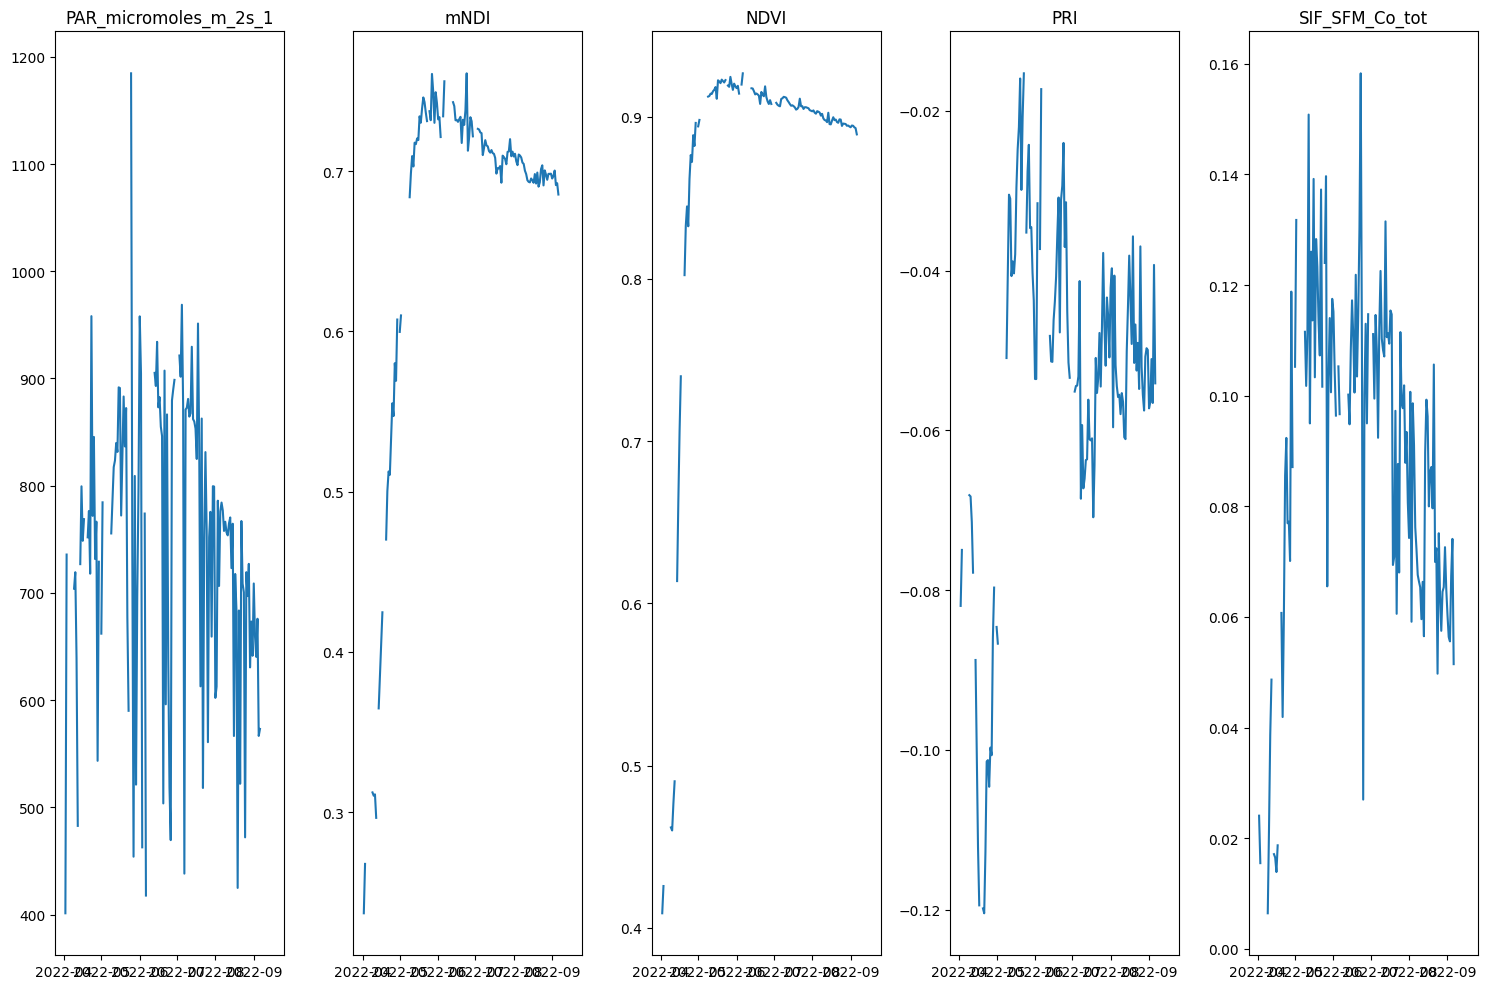

In [85]:

fig, axs = plt.subplots(1, 5, figsize=(15, 10))  # 1 row, 5 columns

variables = ['PAR_micromoles_m_2s_1', 'mNDI', 'NDVI', 'PRI', 'SIF_SFM_Co_tot']
df=filtered_pd_Date
for i, var in enumerate(variables):
    axs[i].plot(df[var].resample('D').mean())
    axs[i].set_title(var)

plt.tight_layout()
plt.show()

##### Pairplot using seaborn

In [113]:
print(p_df_filtered_orig.columns)

Subset_filtered_SpectralData=p_df_filtered_orig[['SIF_SFM_Co_tot','PRI','PAR_micromoles_m_2s_1','mNDI','NDVI']]
print(Subset_filtered_SpectralData)

Index(['PAR_micromoles_m_2s_1', 'mNDI', 'NDVI', 'PRI', 'SIF_SFM_Co_tot'], dtype='object')
                     SIF_SFM_Co_tot      PRI  PAR_micromoles_m_2s_1     mNDI  \
Time_start                                                                     
2022-01-02 03:29:00         0.00006 -0.08960                56.2380  0.20488   
2022-01-02 09:04:00         0.00010 -0.08538                80.8344  0.22024   
2022-01-03 09:23:00         0.00017 -0.10001                55.2183  0.22479   
2022-01-03 10:09:00         0.00024 -0.09735                42.3330  0.20961   
2022-01-04 04:59:00         0.00002 -0.02472                58.1538  0.27805   
...                             ...      ...                    ...      ...   
2022-09-17 11:50:00         0.01151 -0.05874               212.2830  0.69304   
2022-09-17 11:55:00         0.01073 -0.06218               185.4309  0.69122   
2022-09-17 12:00:00         0.00590 -0.06286               161.0817  0.68941   
2022-09-17 12:06:00         0.

In [114]:
start_date = '2022-05-01'
end_date = '2022-08-31'
start_hour = '10:00'
end_hour = '14:00'

filtered_data = Subset_filtered_SpectralData.loc[start_date:end_date].between_time(start_hour, end_hour)
SpectralData_df_30mn = filtered_data.resample('30T').mean()
SpectralData_df_30mn.head()


,SIF_SFM_Co_tot,PRI,PAR_micromoles_m_2s_1,mNDI,NDVI
Time_start,,,,,
2022-05-01 10:00:00,0.116153,-0.086467,790.388010,0.592868,0.891552
2022-05-01 10:30:00,0.104939,-0.087394,574.492800,0.592928,0.893609
2022-05-01 11:00:00,0.092726,-0.079426,547.984033,0.602302,0.893912
2022-05-01 11:30:00,0.067138,-0.072941,437.408813,0.613779,0.897131
2022-05-01 12:00:00,0.037867,-0.068390,224.529700,0.610033,0.897003


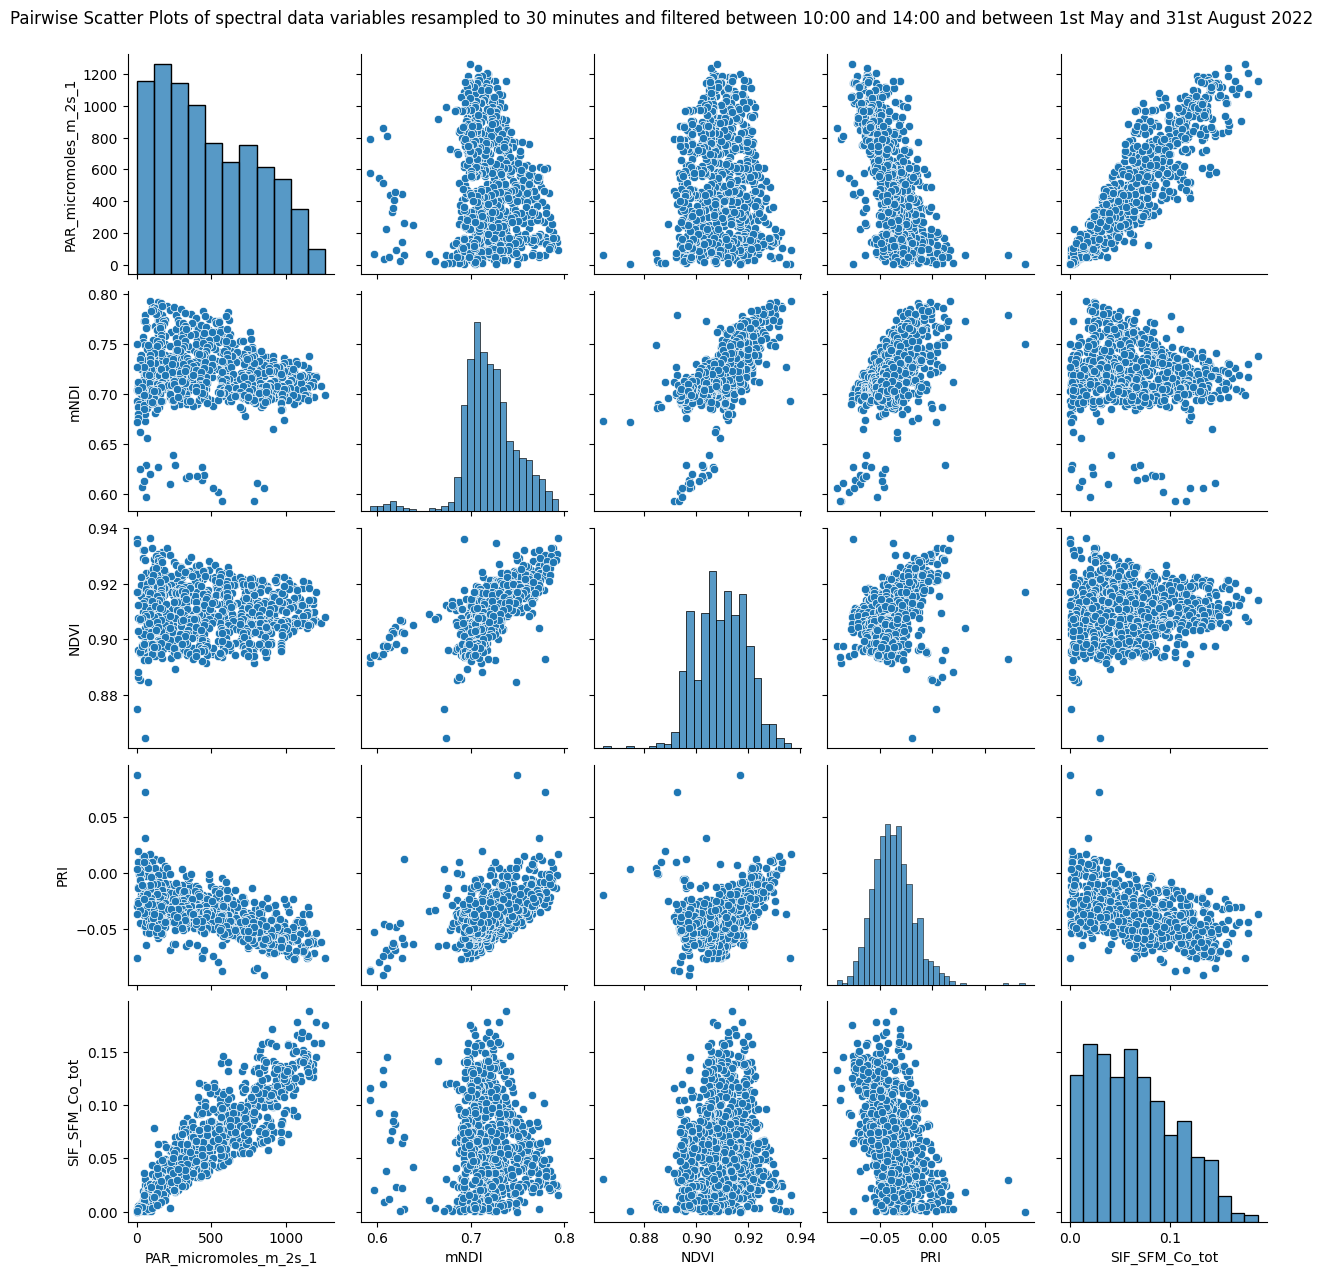

In [118]:
# Assuming `df` is your DataFrame and 'var1', 'var2', 'var3', 'var4' are your variables
import seaborn as sns
sns.pairplot(SpectralData_df_30mn[['PAR_micromoles_m_2s_1', 'mNDI', 'NDVI', 'PRI', 'SIF_SFM_Co_tot']])
plt.suptitle('Pairwise Scatter Plots of spectral data variables resampled to 30 minutes and filtered between 10:00 and 14:00 and between 1st May and 31st August 2022', y=1.02)
plt.show()


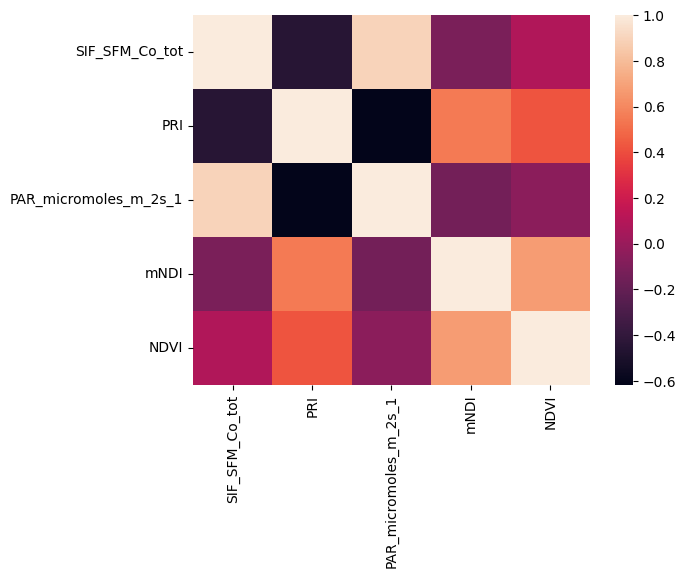

In [119]:
sns.heatmap(SpectralData_df_30mn.corr());

## 4. Open the CSV file and print colnames usin Spark : Flux data

In [120]:
path_name= "D:/ICOS_FrFonSunInducedFluorescence/Flux/"
file_name= "Barbeau_2022_7500_noAoA_uthvar_hh_DIGF.csv"
file=path_name+file_name
print(file)
# Read a CSV file into a DataFrame
df_Flux = spark.read.csv(file, inferSchema=True, header=True, sep=';')
#print(df_SpecData.columns)
# Print column names, each on a new line
for column in df_Flux.columns:
    print("Column name: " + column)

D:/ICOS_FrFonSunInducedFluorescence/Flux/Barbeau_2022_7500_noAoA_uthvar_hh_DIGF.csv
Column name: Date
Column name: an
Column name: mois
Column name: jour
Column name: hh
Column name: jj
Column name: PAR(micromol/m2/s)
Column name: Rg (W/m2)
Column name: Ta (C)
Column name: Tsonic (C)
Column name: RH(%)
Column name: VPD(kPa)
Column name: Pression (hPa)
Column name: Prec(mm)
Column name: WS (m/s)
Column name: ustar (m/s)
Column name: Fc
Column name: Sc
Column name: CO2 (ppmv)
Column name: NEE
Column name: NEE_despiked
Column name: NEE_ustfiltred
Column name: NEEmn
Column name: NEEsd
Column name: NEEpc5
Column name: NEEpc95
Column name: GPP
Column name: GPPsd
Column name: GPPpc5
Column name: GPPpc95
Column name: TER
Column name: TERsd
Column name: TERpc5
Column name: TERpc95
Column name: qc_co2
Column name: flag_NEE_GF
Column name: LE (W/m2)
Column name: LEgf
Column name: H2O (mmol/mol)
Column name: E (mm/hh)
Column name: Fh2o (mmol/m2/s)
Column name: qc_h2o
Column name: flag_LE_GF
Column

In [121]:
from pyspark.sql.functions import to_timestamp

# Convert 'Time_Start' and 'Time_End' to datetime
df_Flux= df_Flux.withColumn("Date", to_timestamp("Date", 'dd/MM/yyyy HH:mm'))


#### 4.1. Select main variables in Flux data

In [127]:
df_Flux_select=df_Flux.select('Date','PAR(micromol/m2/s)','RH(%)','VPD(kPa)','Ta (C)','Prec(mm)','GPP','TER','ETP_Pen(W/m2)')

#### 4.2. Convert pySpark DataFrame to Pandas DataFrame for plotting

In [129]:
p_df_Flux_select_orig= df_Flux_select.toPandas()
p_df_Flux_select_orig['Date'] = pd.to_datetime(p_df_Flux_select_orig['Date'])
p_df_Flux_select_orig.set_index('Date', inplace=True)

c:\Users\salsa\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\pandas\types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
c:\Users\salsa\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\pandas\types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


In [133]:
print(p_df_Flux_select_orig.columns)

Index(['PAR(micromol/m2/s)', 'RH(%)', 'VPD(kPa)', 'Ta (C)', 'Prec(mm)', 'GPP',
       'TER', 'ETP_Pen(W/m2)'],
      dtype='object')


In [140]:
start_date = '2022-05-01'
end_date = '2022-08-31'
start_hour = 10
end_hour = 14

mask = (p_df_Flux_select_orig.index.date >= pd.to_datetime(start_date).date()) & \
       (p_df_Flux_select_orig.index.date <= pd.to_datetime(end_date).date()) & \
       (p_df_Flux_select_orig.index.hour >= start_hour) & \
       (p_df_Flux_select_orig.index.hour <= end_hour)
       
Flux_filtered_pd_Date = p_df_Flux_select_orig.loc[mask]

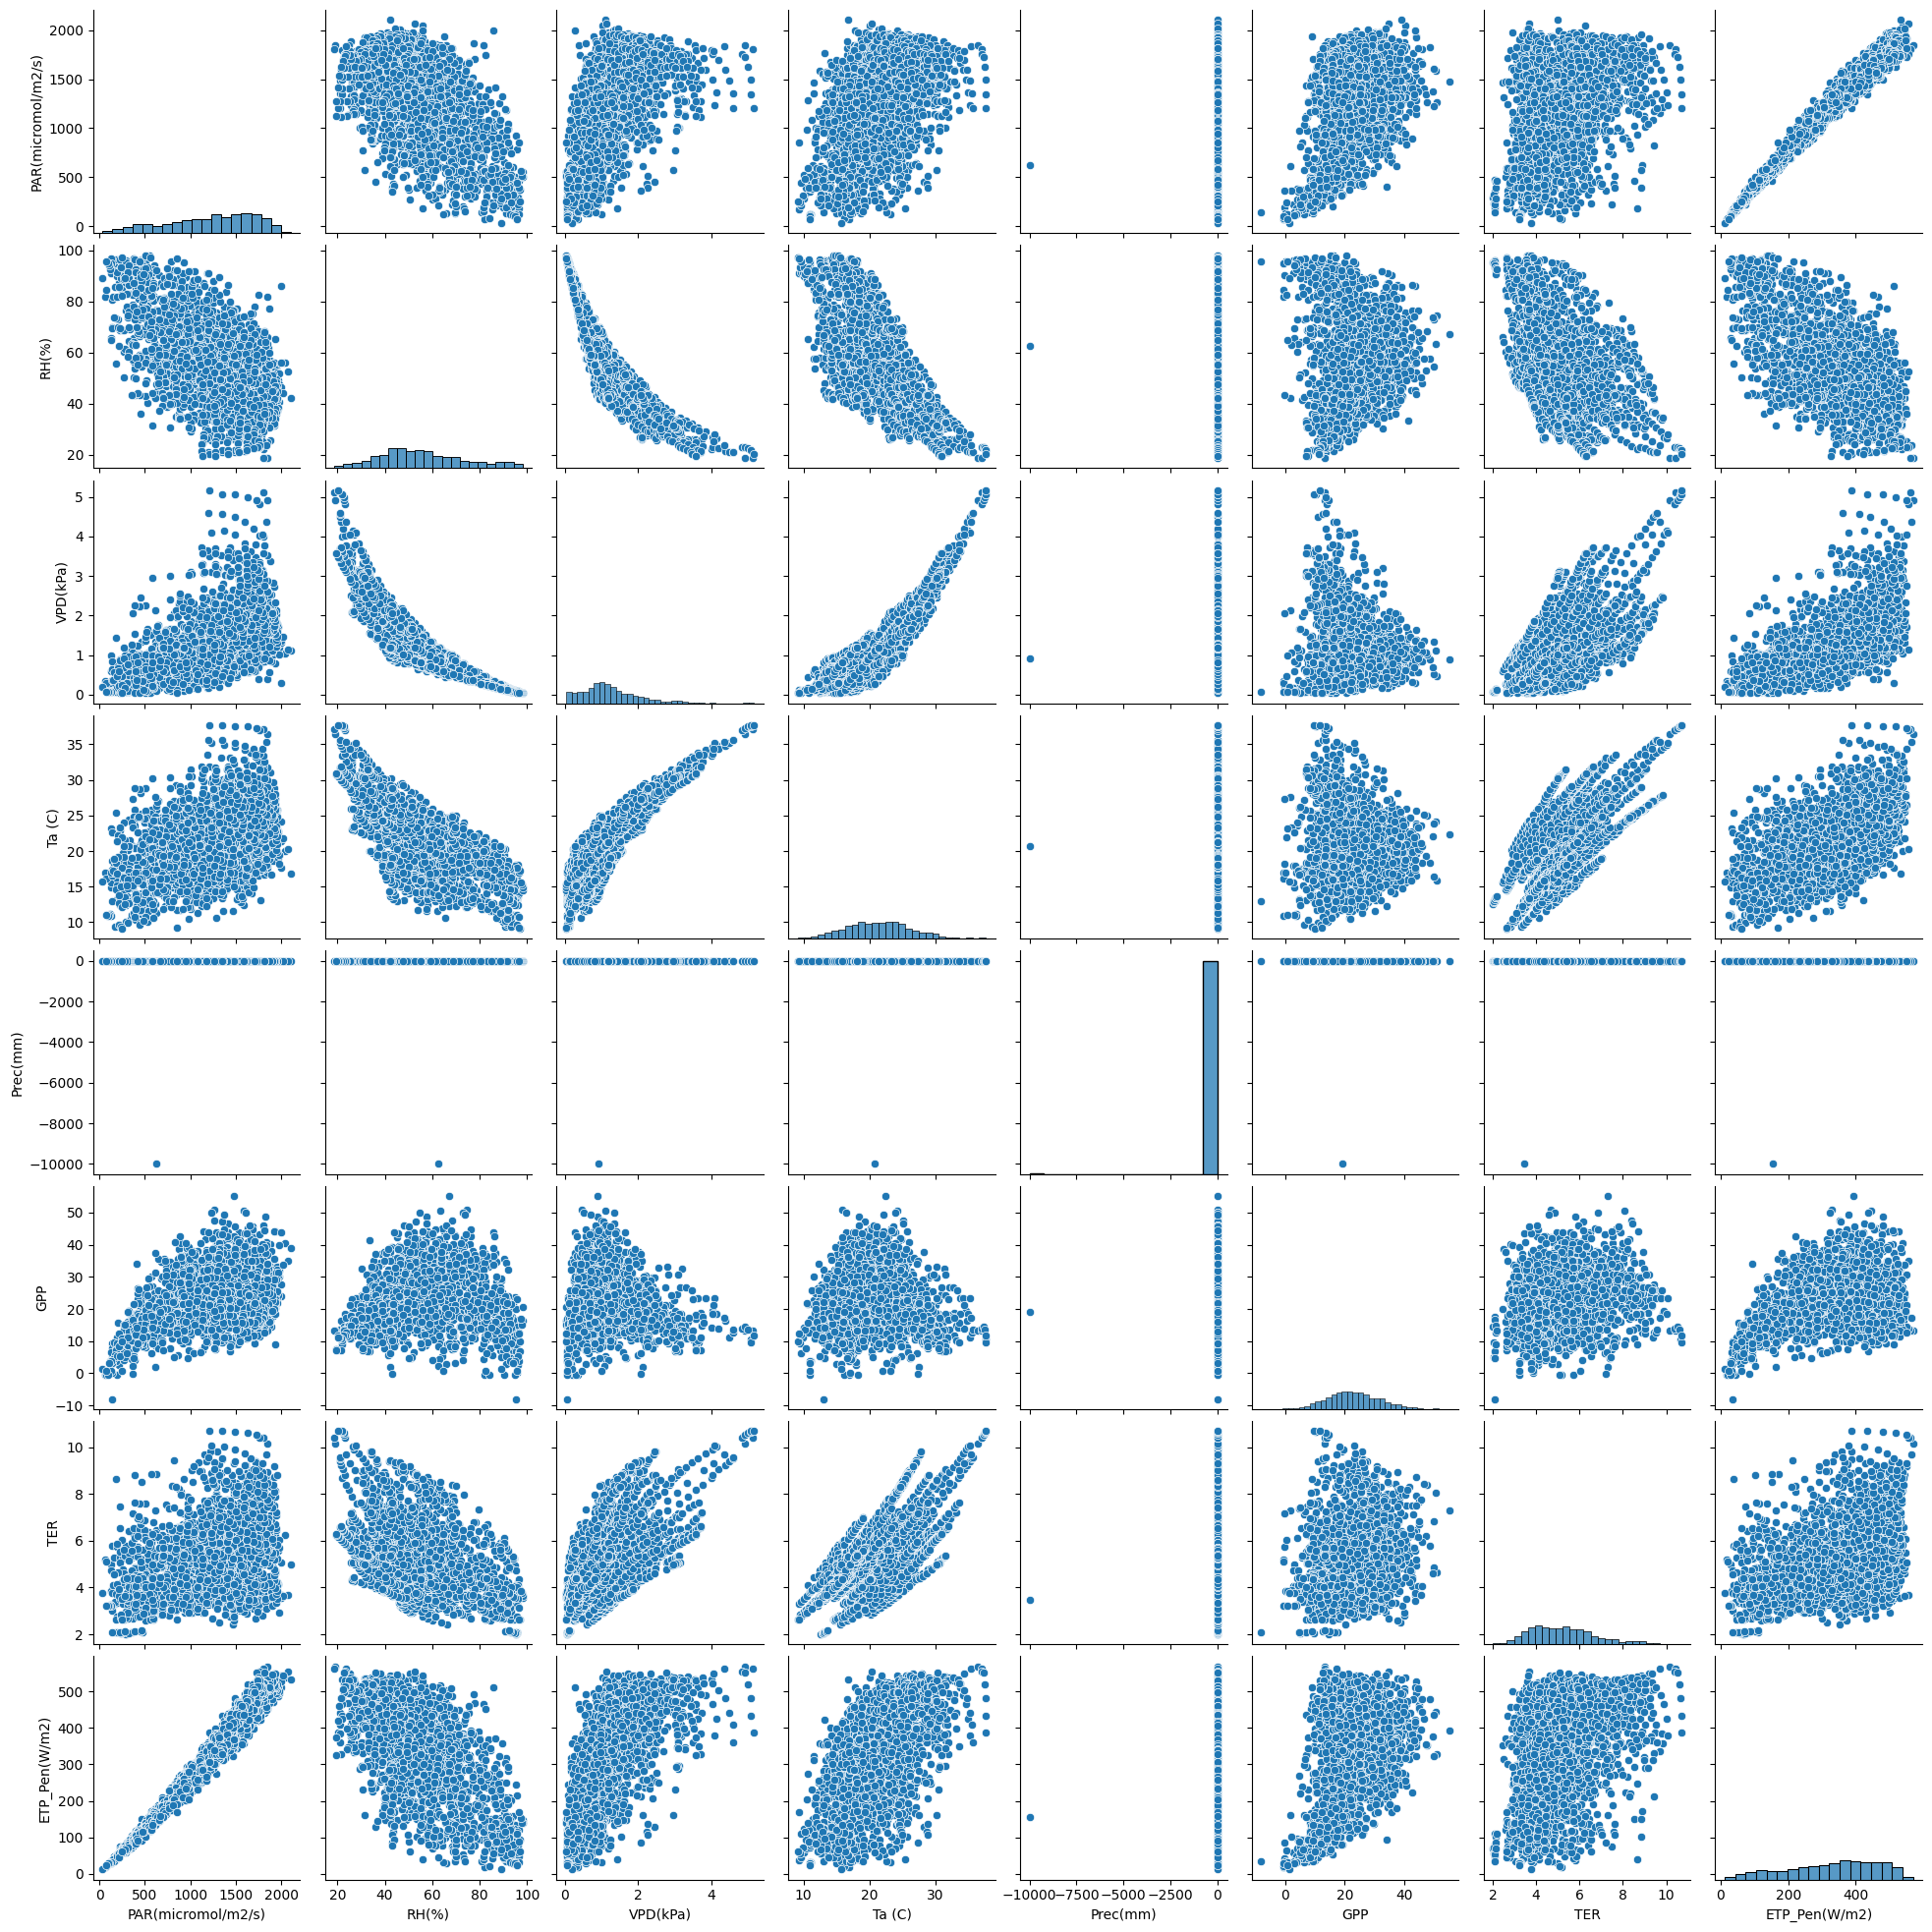

In [20]:
sns.pairplot(Flux_filtered_pd_Date)
plt.show()

## 5. Fusion of Spectral data and Flux data at half hour time step : Resampling using time in PySpark is not easy. Pandas is better
###  To merge the two dataframes using Pandas, merge function need to use the same keey (here timestamp column)

#### 5.1 Set the key columns for the join

In [141]:
# Spectral data : SpectralData_df_30mn resampled every 30mn
Filtered_SpectralData_usedInRF=SpectralData_df_30mn[['SIF_SFM_Co_tot','PRI','PAR_micromoles_m_2s_1','mNDI','NDVI']]
Filtered_SpectralData_usedInRF_30m = Filtered_SpectralData_usedInRF.resample('30T').mean()
Filtered_SpectralData_usedInRF_30m.head()

,SIF_SFM_Co_tot,PRI,PAR_micromoles_m_2s_1,mNDI,NDVI
Time_start,,,,,
2022-05-01 10:00:00,0.116153,-0.086467,790.388010,0.592868,0.891552
2022-05-01 10:30:00,0.104939,-0.087394,574.492800,0.592928,0.893609
2022-05-01 11:00:00,0.092726,-0.079426,547.984033,0.602302,0.893912
2022-05-01 11:30:00,0.067138,-0.072941,437.408813,0.613779,0.897131
2022-05-01 12:00:00,0.037867,-0.068390,224.529700,0.610033,0.897003


In [145]:
Filtered_SpectralData_usedInRF_30m.head()

,SIF_SFM_Co_tot,PRI,PAR_micromoles_m_2s_1,mNDI,NDVI
Time_start,,,,,
2022-05-01 10:00:00,0.116153,-0.086467,790.388010,0.592868,0.891552
2022-05-01 10:30:00,0.104939,-0.087394,574.492800,0.592928,0.893609
2022-05-01 11:00:00,0.092726,-0.079426,547.984033,0.602302,0.893912
2022-05-01 11:30:00,0.067138,-0.072941,437.408813,0.613779,0.897131
2022-05-01 12:00:00,0.037867,-0.068390,224.529700,0.610033,0.897003


In [146]:
Filtered_SpectralData_usedInRF_30m = Filtered_SpectralData_usedInRF_30m.reset_index()
Filtered_SpectralData_usedInRF_30m['index'] = pd.to_datetime(Filtered_SpectralData_usedInRF_30m['Time_start'])
Filtered_SpectralData_usedInRF_30m.rename(columns={'index': 'timestamp'}, inplace=True)
Filtered_SpectralData_usedInRF_30m.head()

,Time_start,SIF_SFM_Co_tot,PRI,PAR_micromoles_m_2s_1,mNDI,NDVI,timestamp
0,2022-05-01 10:00:00,0.116153,-0.086467,790.388010,0.592868,0.891552,2022-05-01 10:00:00
1,2022-05-01 10:30:00,0.104939,-0.087394,574.492800,0.592928,0.893609,2022-05-01 10:30:00
2,2022-05-01 11:00:00,0.092726,-0.079426,547.984033,0.602302,0.893912,2022-05-01 11:00:00
3,2022-05-01 11:30:00,0.067138,-0.072941,437.408813,0.613779,0.897131,2022-05-01 11:30:00
4,2022-05-01 12:00:00,0.037867,-0.068390,224.529700,0.610033,0.897003,2022-05-01 12:00:00


#### 5.2. Check if bad data (Spectral data are acquired at high tempral resolutio - data need to be clean before resampling at 30 min as the same resolution of flux data)

In [147]:

df_description_spectData = Filtered_SpectralData_usedInRF_30m.describe()
df_description_spectData

,Time_start,SIF_SFM_Co_tot,PRI,PAR_micromoles_m_2s_1,mNDI,NDVI,timestamp
count,5864,838.000000,838.000000,838.000000,838.000000,838.000000,5864
mean,2022-07-01 11:44:59.999999744,0.064832,-0.037320,485.270256,0.720396,0.909736,2022-07-01 11:44:59.999999744
min,2022-05-01 10:00:00,0.000000,-0.090733,2.781000,0.592868,0.864440,2022-05-01 10:00:00
25%,2022-05-31 22:52:30,0.029862,-0.050324,190.423181,0.703744,0.903187,2022-05-31 22:52:30
50%,2022-07-01 11:45:00,0.060212,-0.038258,437.582625,0.718431,0.909755,2022-07-01 11:45:00
75%,2022-08-01 00:37:30,0.093850,-0.026154,744.626566,0.736594,0.916869,2022-08-01 00:37:30
max,2022-08-31 13:30:00,0.188071,0.087400,1263.823905,0.793380,0.936627,2022-08-31 13:30:00
std,NaN,0.041816,0.019285,324.698333,0.029856,0.009531,NaN


In [155]:
p_df_Flux_select_orig.head

<bound method NDFrame.head of                      PAR(micromol/m2/s)     RH(%)  VPD(kPa)    Ta (C)  \
Date                                                                    
2022-01-01 00:30:00                 0.0  96.55000  0.042133  9.918333   
2022-01-01 01:00:00                 0.0  96.84167  0.038091  9.731666   
2022-01-01 01:30:00                 0.0  96.76333  0.038688  9.598332   
2022-01-01 02:00:00                 0.0  97.11500  0.033989  9.383332   
2022-01-01 02:30:00                 0.0  97.33334  0.031076  9.221666   
...                                 ...       ...       ...       ...   
2022-11-30 22:00:00                 0.0  94.53500  0.049099  5.423333   
2022-11-30 22:30:00                 0.0  95.19499  0.042091  5.059999   
2022-11-30 23:00:00                 0.0  95.26833  0.041026  4.913333   
2022-11-30 23:30:00                 0.0  94.85166  0.044441  4.850000   
2022-12-01 00:00:00                 0.0  94.66000  0.046236  4.893333   

                    

In [158]:

p_df_Flux_select = p_df_Flux_select_orig.replace(-9999, pd.NA)

p_df_Flux_select=p_df_Flux_select.reset_index()
p_df_Flux_select['timestamp'] = pd.to_datetime(p_df_Flux_select['Date'])

p_df_Flux_select.head()


,Date,PAR(micromol/m2/s),RH(%),VPD(kPa),Ta (C),Prec(mm),GPP,TER,ETP_Pen(W/m2),timestamp
0,2022-01-01 00:30:00,0.0,96.55000,0.042133,9.918333,0.0,0.0,3.192912,0.507754,2022-01-01 00:30:00
1,2022-01-01 01:00:00,0.0,96.84167,0.038091,9.731666,0.0,0.0,1.905954,0.493251,2022-01-01 01:00:00
2,2022-01-01 01:30:00,0.0,96.76333,0.038688,9.598332,0.0,0.0,3.838458,0.478289,2022-01-01 01:30:00
3,2022-01-01 02:00:00,0.0,97.11500,0.033989,9.383332,0.0,0.0,5.931380,0.482649,2022-01-01 02:00:00
4,2022-01-01 02:30:00,0.0,97.33334,0.031076,9.221666,0.0,0.0,1.986196,0.355139,2022-01-01 02:30:00


#### 5.2. Merge Spectral and Flux dataframes    

In [162]:
# Merge dataframes based on 'timestamp'

SpecData_Flux_Merged = pd.merge(p_df_Flux_select, Filtered_SpectralData_usedInRF_30m, on='timestamp', how='inner')

# Display the merged dataframe
print(SpecData_Flux_Merged)


                    Date  PAR(micromol/m2/s)     RH(%)  VPD(kPa)    Ta (C)  \
0    2022-05-01 10:00:00            1282.772  65.37666  0.444977  10.68167   
1    2022-05-01 10:30:00            1468.257  62.23000  0.515482  11.58667   
2    2022-05-01 11:00:00            1585.977  57.97833  0.604643  12.38833   
3    2022-05-01 11:30:00            1557.213  55.20667  0.663405  12.82833   
4    2022-05-01 12:00:00            1511.190  53.33333  0.712562  13.29500   
...                  ...                 ...       ...       ...       ...   
5859 2022-08-31 11:30:00            1460.748  55.83333  1.149709  21.74500   
5860 2022-08-31 12:00:00            1525.085  54.47000  1.229080  22.34167   
5861 2022-08-31 12:30:00            1563.499  52.45833  1.339428  23.04667   
5862 2022-08-31 13:00:00            1574.074  50.54166  1.452630  23.73667   
5863 2022-08-31 13:30:00            1572.422  48.25166  1.588544  24.47333   

     Prec(mm)        GPP       TER  ETP_Pen(W/m2)           tim

### 6. Data preparation for Random Forest Regression

#### 6.1. Filtering over time

In [163]:
start_date = '2022-05-01'
end_date = '2022-08-31'
start_hour = 10
end_hour = 14
SpecData_Flux_Merged=SpecData_Flux_Merged.set_index('timestamp')
mask = (SpecData_Flux_Merged.index.date >= pd.to_datetime(start_date).date()) & \
       (SpecData_Flux_Merged.index.date <= pd.to_datetime(end_date).date()) & \
       (SpecData_Flux_Merged.index.hour >= start_hour) & \
       (SpecData_Flux_Merged.index.hour <= end_hour)

SpecData_Flux_Merged_filtered = SpecData_Flux_Merged.loc[mask]

In [31]:
SpecData_Flux_Merged_filtered.head()

,Date,PAR(micromol/m2/s),RH(%),VPD(kPa),Ta (C),Prec(mm),GPP,TER,ETP_Pen(W/m2),Time_start,SIF_SFM_Co_tot,PRI,PAR_micromoles_m_2s_1,mNDI,NDVI
timestamp,,,,,,,,,,,,,,,
2022-05-15 08:00:00,2022-05-15 08:00:00,528.9119,58.76667,0.792180,16.86500,0.0,30.730019,5.216459,118.240839,2022-05-15 08:00:00,0.217070,-0.047584,1526.303293,0.701914,0.917699
2022-05-15 08:30:00,2022-05-15 08:30:00,880.6887,55.67333,0.914706,17.99667,0.0,43.017737,5.625337,219.523020,2022-05-15 08:30:00,0.162547,-0.040063,1231.689450,0.709051,0.919382
2022-05-15 09:00:00,2022-05-15 09:00:00,1080.2210,51.76500,1.082605,19.34000,0.0,17.632988,6.131688,285.963158,2022-05-15 09:00:00,0.143149,-0.039735,1029.795873,0.706591,0.918194
2022-05-15 09:30:00,2022-05-15 09:30:00,863.9784,50.93166,1.154121,20.09500,0.0,24.939529,6.426029,225.848167,2022-05-15 09:30:00,0.190909,-0.044175,1233.581560,0.707663,0.917590
2022-05-15 10:00:00,2022-05-15 10:00:00,1313.8710,48.74333,1.300029,21.32000,0.0,27.822320,6.918620,356.102699,2022-05-15 10:00:00,0.152233,-0.045243,1117.945520,0.711527,0.918492


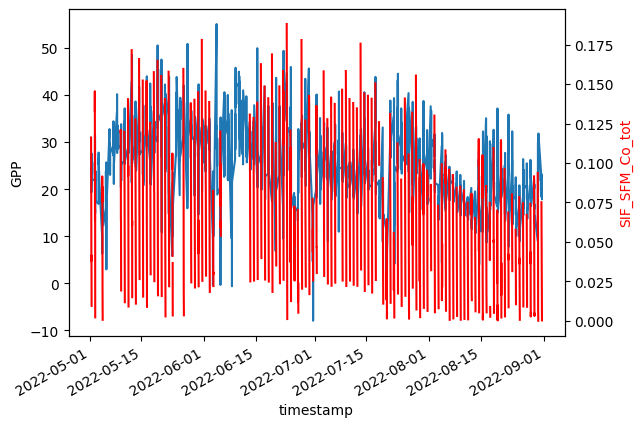

In [164]:
ax1 = SpecData_Flux_Merged_filtered['GPP'].plot()
ax2 = ax1.twinx()
SpecData_Flux_Merged_filtered['SIF_SFM_Co_tot'].plot(ax=ax2, color='r')

ax1.set_ylabel('GPP')
ax2.set_ylabel('SIF_SFM_Co_tot', color='r')
plt.show()

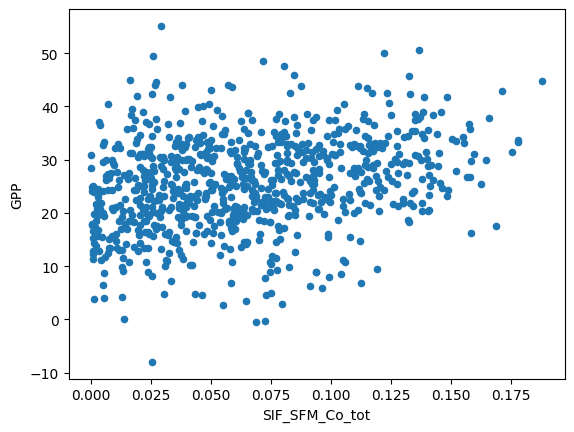

In [165]:
# Assuming 'SpecData_Flux_Merged' is your DataFrame
SpecData_Flux_Merged_filtered.plot.scatter(x='SIF_SFM_Co_tot', y='GPP')
plt.show()

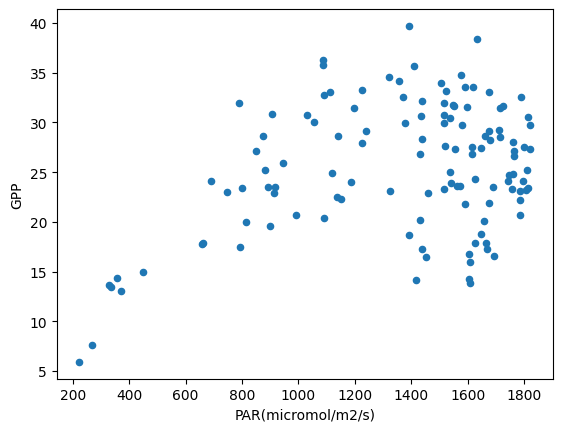

In [167]:
# Assuming 'df' is your DataFrame, 'timestamp' is your timestamp column,
# 'GPP' is the column you want on the x-axis, and 'SIF' is the column you want on the y-axis

df_daily = SpecData_Flux_Merged_filtered.resample('D').mean()

df_daily.plot.scatter(x='SIF_SFM_Co_tot', y='GPP')
plt.show()

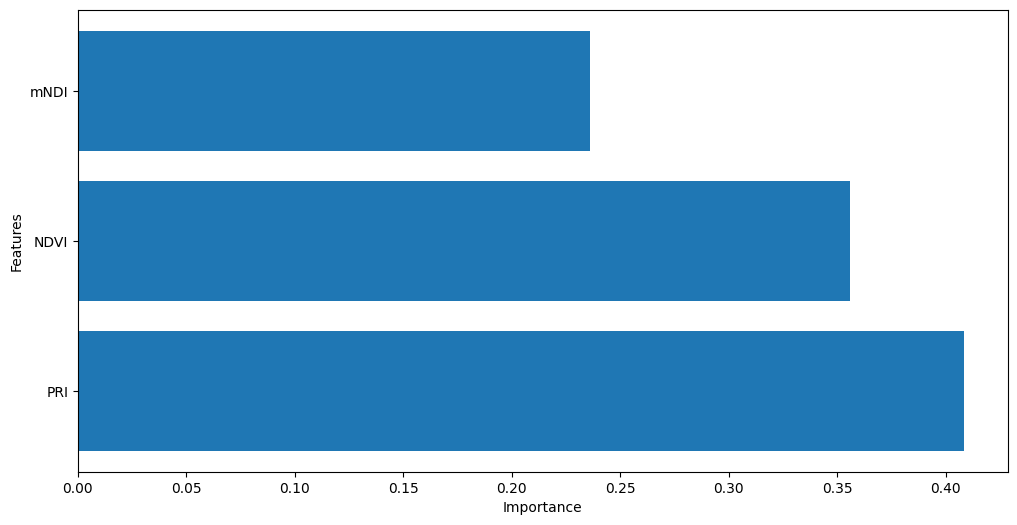

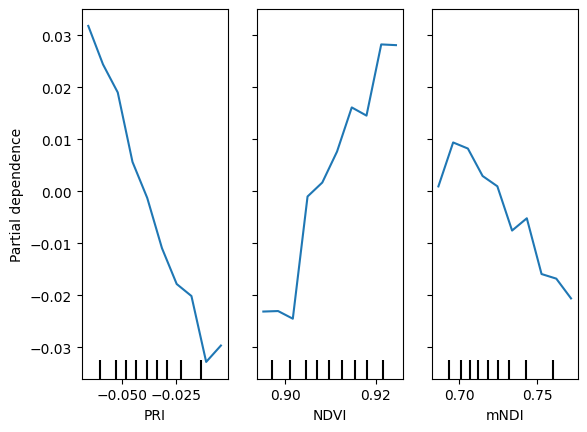

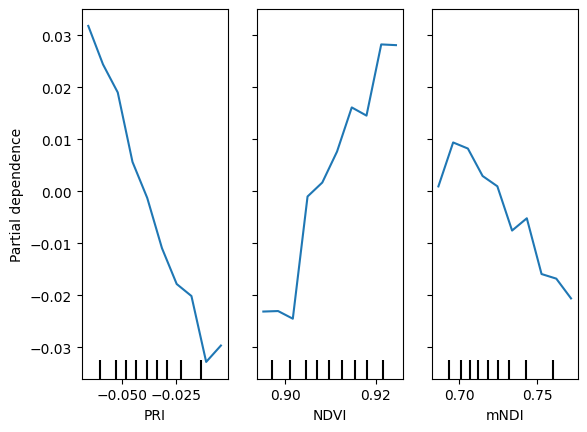

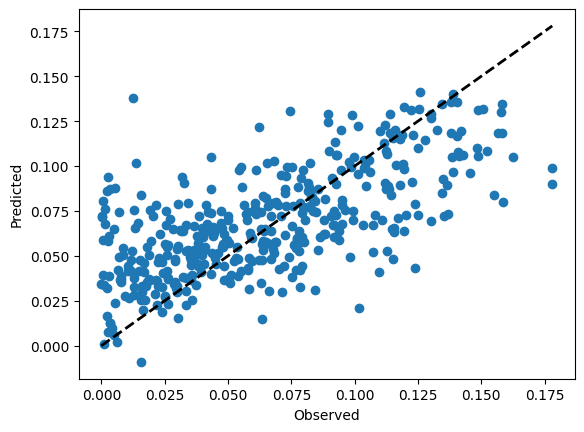

In [168]:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
SpecData_Flux_Merged_filtered=SpecData_Flux_Merged_filtered.dropna()

X = SpecData_Flux_Merged_filtered[['PRI', 'NDVI', 'mNDI']]
y = SpecData_Flux_Merged_filtered['SIF_SFM_Co_tot']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

my_model = GradientBoostingRegressor()
my_model.fit(X_train, y_train)
features = [0, 1, 2]  # column numbers of plots we want to show
feature_names = ['PRI', 'NDVI', 'mNDI']  # labels on graphs
# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_names, my_model.feature_importances_)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Plot partial dependence
features = [0, 1, 2]  # column numbers of plots we want to show
feature_names = ['PRI', 'NDVI', 'mNDI']  # labels on graphs
disp = PartialDependenceDisplay.from_estimator(
    my_model,
    X,
    features,
    feature_names=feature_names,
    grid_resolution=10,
)
disp.plot()
plt.show()

# Predict the target variable for the testing data
y_pred = my_model.predict(X_test)

# Plot observed vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

In [169]:
print(SpecData_Flux_Merged_filtered.columns)

Index(['Date', 'PAR(micromol/m2/s)', 'RH(%)', 'VPD(kPa)', 'Ta (C)', 'Prec(mm)',
       'GPP', 'TER', 'ETP_Pen(W/m2)', 'Time_start', 'SIF_SFM_Co_tot', 'PRI',
       'PAR_micromoles_m_2s_1', 'mNDI', 'NDVI'],
      dtype='object')


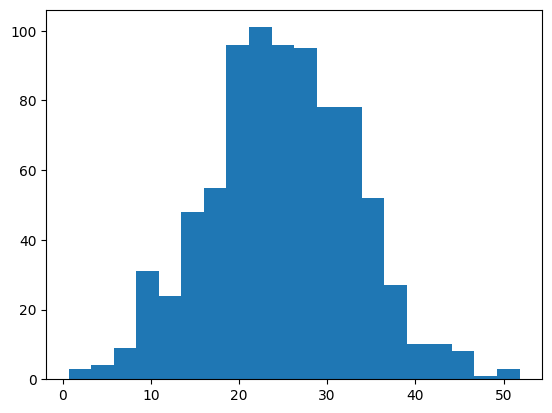

['PRI', 'NDVI', 'mNDI', 'SIF_SFM_Co_tot']


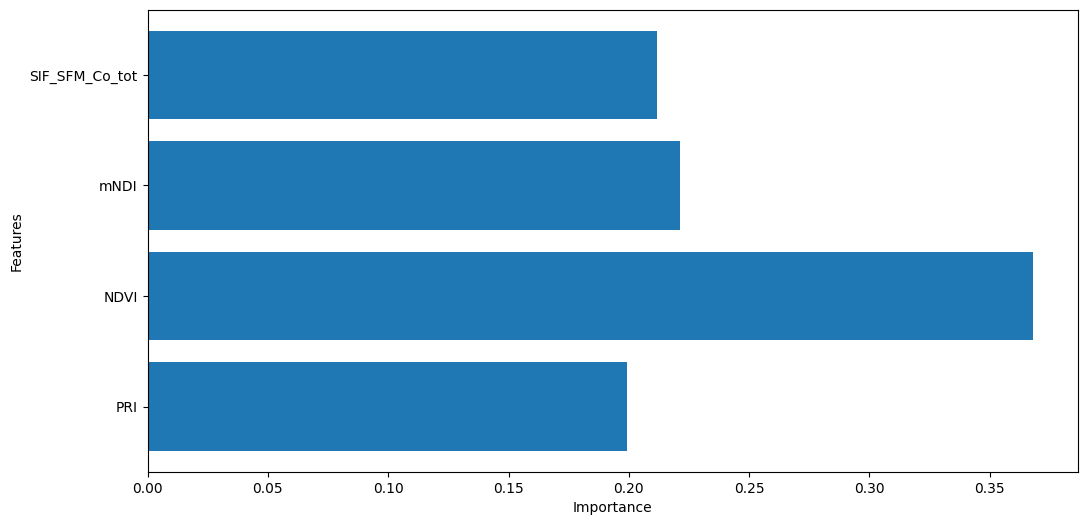

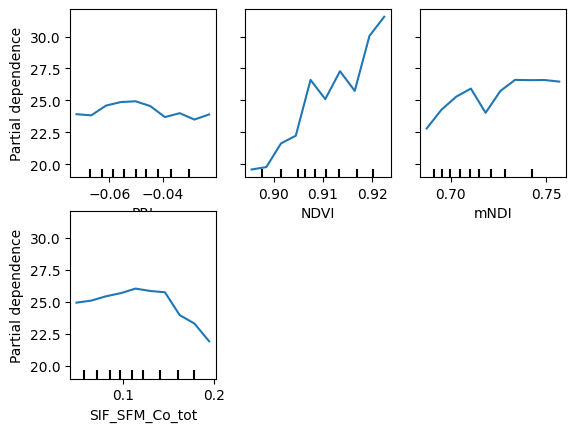

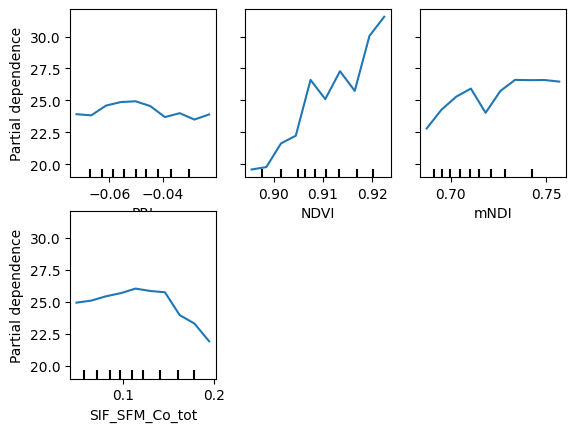

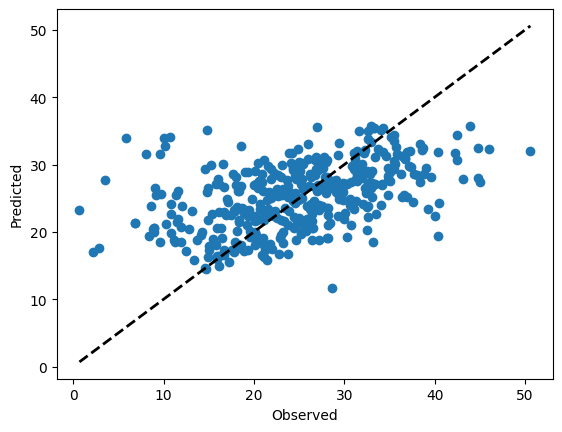

In [37]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
SpecData_Flux_Merged_filtered_used=SpecData_Flux_Merged_filtered[(SpecData_Flux_Merged_filtered['PAR(micromol/m2/s)']>= 0) & (SpecData_Flux_Merged_filtered['GPP'] > 0)]
X = SpecData_Flux_Merged_filtered_used[['PRI', 'NDVI', 'mNDI','SIF_SFM_Co_tot']]
y = SpecData_Flux_Merged_filtered_used['GPP']
plt.hist('GPP', bins=20, data=SpecData_Flux_Merged_filtered_used)
plt.show()
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

my_model = RandomForestRegressor()
my_model.fit(X_train, y_train)
features = [0, 1, 2, 3]  # column numbers of plots we want to show
feature_names = ['PRI', 'NDVI', 'mNDI','SIF_SFM_Co_tot']  # labels on graphs

print(feature_names)
# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_names, my_model.feature_importances_)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Plot partial dependence
featuresd = [0, 1, 2, 3]  # column numbers of plots we want to show
feature_namesd = ['PRI', 'NDVI', 'mNDI','SIF_SFM_Co_tot']  # labels on graphs
disp = PartialDependenceDisplay.from_estimator(
    my_model,
    X,
    features,
    feature_names=feature_namesd,
    grid_resolution=10,
)
disp.plot()
plt.show()

# Predict the target variable for the testing data
y_pred = my_model.predict(X_test)

# Plot observed vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

In [170]:
#SpecData_Flux_Merged_filtered.to_csv('Ecosystem_Data2022.csv', sep=';', index=False)